# SPAM CLASSIFIER

## 1. Data access

In [1]:
import os

DATASETS_DIR = 'datasets'
MODELS_DIR = 'models'
TAR_DIR = os.path.join(DATASETS_DIR, 'tar')

SPAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2'
EASY_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2'
HARD_HAM_URL = 'https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2'


In [2]:
# Download and extract the contents of a tar archive from the URL

from urllib.request import urlretrieve
import tarfile
import shutil

def download_dataset(url):
    """download and unzip data from a url into the specified path"""
    
    # create directory if it doesn't exist
    if not os.path.isdir(TAR_DIR):
        os.makedirs(TAR_DIR)
    
    filename = url.rsplit('/', 1)[-1]
    tarpath = os.path.join(TAR_DIR, filename)
    
    # download the tar file if it doesn't exist
    try:
        tarfile.open(tarpath)
    except:
        urlretrieve(url, tarpath)
    
    with tarfile.open(tarpath) as tar:
        dirname = os.path.join(DATASETS_DIR, tar.getnames()[0])
        if os.path.isdir(dirname):
            shutil.rmtree(dirname)
        tar.extractall(path=DATASETS_DIR)
        
        cmds_path = os.path.join(dirname, 'cmds')
        if os.path.isfile(cmds_path):
            os.remove(cmds_path)
    
    return dirname


In [3]:
# download the data
spam_dir = download_dataset(SPAM_URL)
easy_ham_dir = download_dataset(EASY_HAM_URL)
hard_ham_dir = download_dataset(HARD_HAM_URL)

In [4]:
import numpy as np
import glob

def load_dataset(dirpath):
    """load emails from the specified directory"""
    
    files = []
    filepaths = glob.glob(dirpath + '/*')
    for path in filepaths:
        with open(path, 'rb') as f:
            byte_content = f.read()
            str_content = byte_content.decode('utf-8', errors='ignore')
            files.append(str_content)
    return files
    

In [5]:
# load the datasets
spam = load_dataset(spam_dir)
easy_ham = load_dataset(easy_ham_dir)
hard_ham = load_dataset(hard_ham_dir)

In [6]:
import sklearn.utils

# create the full dataset
X = spam + easy_ham + hard_ham
y = np.concatenate((np.ones(len(spam)), np.zeros(len(easy_ham) + len(hard_ham))))  # 1 for spam, 0 for non-spam

# shuffle the dataset
X, y = sklearn.utils.shuffle(X, y, random_state=42)

In [7]:
from sklearn.model_selection import train_test_split

# split the data into stratified training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=42)



In [8]:
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

2436 2436
610 610


## 2. Data preparation

- Remove Headers: You might want to remove or selectively process email headers, as they can contain a lot of technical data that may not be useful for your analysis.
- Handle HTML Content: If the email body contains HTML, strip out the HTML tags to leave just the text.
- Lowercasing: Convert all text to lowercase to ensure uniformity, as case usually doesn't affect spamminess.
- Remove Special Characters and Numbers: You might want to remove numbers and special characters, depending on your focus. For spam detection, some characters or number patterns could be relevant, so this step should be considered carefully.
- Tokenization: Break the text into individual words or tokens

#### Removing the headers

Email headers are usually followed by a double newline (\n\n), separating them from the body. We can split the text at the first occurrence of \n\n and take the part after it as the email body.

In [9]:
def remove_email_headers(email_text):
    """
    Removes headers from an email.
    Assumes headers and body are separated by a \n\n
    """
    parts = email_text.split('\n\n', 1)  # one split only
    if len(parts) > 1:   #Everything after the \n\n is the body
        return parts[1]
    else:
        return email_text  # Return original if no headers found


# Example usage
email_with_headers = "From: sender@example.com\nSubject: Test Email\n\nThis is the email body."
email_body = remove_email_headers(email_with_headers)
print(email_body)


This is the email body.


#### Handle HTML content

Email headers are usually followed by a double newline (\n\n), separating them from the body. We can split the text at the first occurrence of \n\n and take the part after it as the email body.

In [10]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs = True
        self.fed = []

    def handle_data(self, d):
        self.fed.append(d)

    def get_data(self):
        return ''.join(self.fed)
    
    
def strip_tags(html):   # This function removes the HTML tags
    s = MLStripper()
    s.feed(html)
    return s.get_data()


# Example usage
html_content = "<html><body><p>This is a <b>test</b> email.</p></body></html>"
text_only = strip_tags(html_content)
print(text_only)

This is a test email.


#### Text homogenization

- First, we'll create a function to convert the URL directions into just 'URL'.
- Then, all the numbers we'll be transformed into 'NUM'. This can be useful to normalize or reduce the variability of the text.
- The last function removes all the punctuation signs and returns everything in lowecase to ensure uniformity.


In [11]:
import re 

def is_url(s):
    url = re.match("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|"
                     "[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", s)
    return url is not None

def convert_url_to_word(words):
    """convert all urls in the list to the word 'URL'"""
    for i, word in enumerate(words):
        if is_url(word):
            words[i] = 'URL'
    return words

In [12]:
def convert_num_to_word(words):
    """convert all numbers in the list to the word 'NUM'"""
    for i, word in enumerate(words):
        if word.isdigit():
            words[i] = 'NUM'
    return words

In [13]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ihona\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ihona\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Using NLTK library

NLTK is a library that enables us to preprocess text data for further analysis. Tokenization is the process of breaking down text into smaller units, typically words or phrases. In this function, tokenization is achieved by first removing punctuation and replacing tabs and newlines with spaces, and then splitting the text into individual words (or "tokens") based on spaces.
The function below performs several steps:

    1. Remove Punctuation: Removes all punctuation from the text to focus only on words
    2. Replace Tabs and New Lines: Converts tabs (\t) and new lines (\n) to spaces for consistent whitespace handling.
    3. Split into Words and Remove Stopwords: Splits the text into words and filters out any empty tokens and words that are in the list of stopwords.
    4. Apply Stemming: Each word is then stemmed using the Porter Stemmer. Stemming is the process of reducing words to their base or root form. For example, "running", "runs", and "ran" are all reduced to the stem "run". 
    5. Return Processed Tokens: The function returns a list of these processed and stemmed tokens.

In [14]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

def tokenize_email(text):
    """
    Tokenize a text string. This involves removing punctuation, 
    replacing tabs and newlines with spaces, splitting into words, 
    and then applying stemming. It also filters out stopwords.

    :param text: The string to be tokenized.
    :return: A list of stemmed tokens.
    """
    # Initialize stemmer and stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Replace tabs and new lines with spaces
    text = text.replace("\t", " ").replace("\n", " ")

    # Split into words and filter out empty tokens and stopwords
    tokens = [word for word in text.split(" ") if word and word not in stop_words]

    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    return stemmed_tokens

# Example usage
sample_email = "Hello, world! This is an example email, with punctuations and stopwords."
tokenized_email = tokenize_email(sample_email)

print(tokenized_email)


['hello', 'world', 'thi', 'exampl', 'email', 'punctuat', 'stopword']


#### CUSTOM TRANSFORMER AND PIPELINE

Let's create a custom transformer and pipeline to apply all the processing steps in order.

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class ProcessEmail(BaseEstimator, TransformerMixin):
    def __init__(self, header=True, strip=True, url_to_word=True, num_to_word=True,
                 remove_punc=True, tokenize_email=True,):
        self.header = header
        self.strip = strip
        self.url_to_word = url_to_word
        self.num_to_word = num_to_word
        self.remove_punc = remove_punc
        self.tokenize_email=tokenize_email
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_cleaned = []
        for email in X:
            if self.header:
                email = remove_email_headers(email)
                
            if self.strip:
                email_stripped=strip_tags(email)
            
            if self.tokenize_email:
                email_tokenized = tokenize_email(email_stripped)
                
            if self.url_to_word:
                email_words = convert_url_to_word(email_tokenized)   
                
            if self.num_to_word:
                email_words = convert_num_to_word(email_words)
            email = ' '.join(email_words)
            
            if self.remove_punc:
                email = email.lower()



            X_cleaned.append(email)
            
        return X_cleaned

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# full preparation pipeline
prepare_pipeline = Pipeline([
    ('clean_email', ProcessEmail()),
    ('bag_of_words', CountVectorizer())
])

# CountVectorizer converts a collection of tokenized text documents into a matrix of token counts.

In [17]:
prepare_pipeline

Pipeline(steps=[('clean_email', ProcessEmail()),
                ('bag_of_words', CountVectorizer())])

In [18]:
X_train_prepared = prepare_pipeline.fit_transform(X_train)

In [19]:
print(X_train_prepared.shape)

(2436, 52454)


## 3. Classifiers train and evaluation

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings

# stop scikit-learn's deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)



Training different classifiers:
- SGD classifier
- Decision tree
- Random forest
- SVC

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# classification models
sgd_clf = SGDClassifier(random_state=42, max_iter=100)
tree_clf = DecisionTreeClassifier()
forest_clf = RandomForestClassifier()
svm_clf = SVC()

classifiers = {
    'SGD': sgd_clf,
    'Decision Tree': tree_clf,
    'Random Forest': forest_clf,
    'SVM': svm_clf,
}


In [22]:
from sklearn.model_selection import cross_val_predict

# make predictions using each model
y_preds = {}
for clf_name, clf in classifiers.items():
    y_preds[clf_name] = cross_val_predict(clf, X_train_prepared, y_train, cv=3)

In [23]:
from sklearn.metrics import accuracy_score

# evaluate each classifier's accuracy
for clf_name, y_pred in y_preds.items():
    print("{}:".format(clf_name))
    print(accuracy_score(y_train, y_pred))
    print()

SGD:
0.965927750410509

Decision Tree:
0.9261083743842364

Random Forest:
0.9638752052545156

SVM:
0.9142036124794746



At the moment the two most promisings are SGD and Random forest. Let's evaluate them a bit further.

In [24]:
from sklearn.model_selection import cross_val_predict

# calculate scores for each model
y_scores = {}
clf_thresholds = {}

for clf_name, clf in classifiers.items():
    method = 'predict_proba'
    if not hasattr(clf, 'predict_proba') and hasattr(clf, 'decision_function'):
        method = 'decision_function'
    y_scores[clf_name] = cross_val_predict(clf, X_train_prepared, y_train, cv=3,
                                           method=method)
    if method == 'predict_proba':
        y_scores[clf_name] = y_scores[clf_name][:,1]
        clf_thresholds[clf_name] = 0.5
    else:
        clf_thresholds[clf_name] = 0

In [25]:
# EVALUATION FUNCTION

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def eval_confusion(y_pred, y_true=y_train):
    conf_matrix = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'matrix': conf_matrix, 'precision': precision, 'recall': recall, 'f1': f1}


##### PRECISION-RECALL CURVE

In [26]:
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(y_scores, threshold=0, label=None, style='b-'):
    """plot precision vs recall for different thresholds, highlight the specified threshold"""
    
    # calculate scores and precisions and recalls at different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    # plot the precision and recall curves
    plt.plot(recalls, precisions, style, label=label)
    
    # highlight the threshold
    y_pred = y_scores >= threshold
    hl_precision = precision_score(y_train, y_pred)
    hl_recall = recall_score(y_train, y_pred)
    
    plt.plot([0, hl_recall], [hl_precision, hl_precision], 'r:')
    plt.plot([hl_recall, hl_recall], [0, hl_precision], 'r:')
    plt.plot([hl_recall], [hl_precision], 'ro')

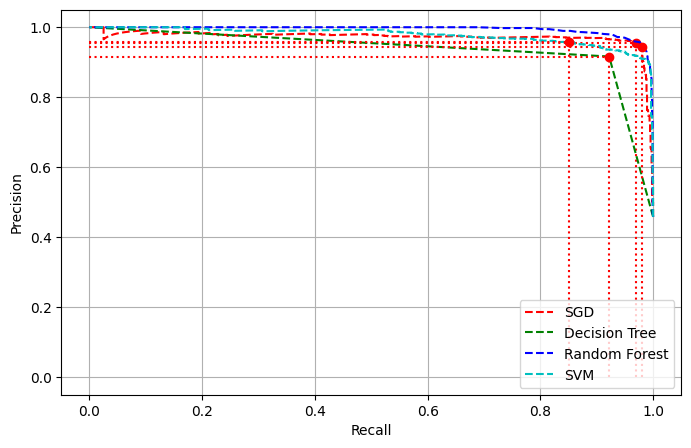

In [27]:
# plot recall vs precision for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

styles = {
    'SGD': 'r--',
    'Decision Tree': 'g--',
    'Random Forest': 'b--',
    'SVM': 'c--'

}

for clf_name, y_score in y_scores.items():
    plot_precision_vs_recall(y_score, threshold=clf_thresholds[clf_name], label=clf_name,
                             style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()


SDG and random forest seem to have the better precision-recall tradeoff.  The most optimal point on the PR curve should be (1,1)

##### ROC - CURVE

In [28]:
from sklearn.metrics import roc_curve

def plot_roc(y_scores, threshold=0, label=None, style='b-'):
    """plot the ROC curve"""
    
    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    
    # plot the ROC curve
    plt.plot(fpr, tpr, style, label=label)
    
    # false positive rate: false positives / true negatives + false positives
    # true positive rate (recall): true positives / (true positives + false negatives)
    # highlight the threshold
    y_pred = y_scores > threshold
    hl_fp = np.sum(np.logical_and(y_pred == True, y_train == 0))
    hl_tp = np.sum(np.logical_and(y_pred == True, y_train == 1))
    hl_fpr = hl_fp / np.sum(y_train == 0)
    hl_tpr = hl_tp / np.sum(y_train == 1)
    
    plt.plot([0, hl_fpr], [hl_tpr, hl_tpr], 'r:')
    plt.plot([hl_fpr, hl_fpr], [0, hl_tpr], 'r:')
    plt.plot([hl_fpr], [hl_tpr], 'ro')

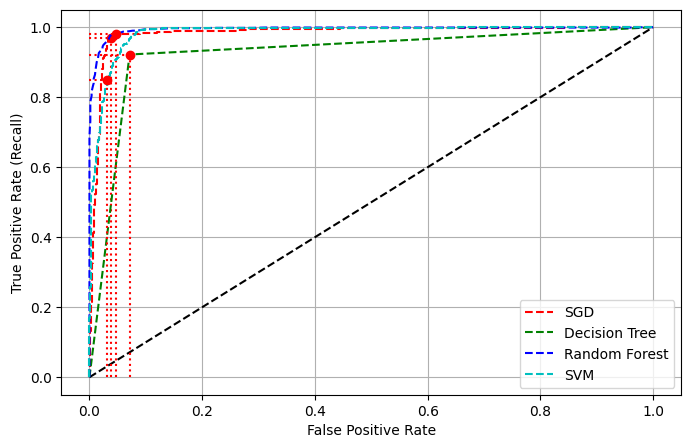

In [29]:
# plot ROC curve for each model
mpl.style.use('default')
plt.figure(figsize=(8, 5))

# ROC for purely random classifier
plt.plot([0, 1], [0, 1], 'k--')

for clf_name, y_score in y_scores.items():
    plot_roc(y_score, threshold=clf_thresholds[clf_name], label=clf_name, style=styles[clf_name])
    
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='lower right')
plt.show()

In [30]:
# calculate all ROC AUCs
from sklearn.metrics import roc_auc_score

print("ROC AUC scores:")
for clf_name, y_score in y_scores.items():
    roc_auc = roc_auc_score(y_train, y_score)
    print("- {}: {}".format(clf_name, roc_auc))


ROC AUC scores:
- SGD: 0.982886662322146
- Decision Tree: 0.9254154447702834
- Random Forest: 0.994470240034756
- SVM: 0.9840345660910177


The best models so far are the SDG and random forest. SVM also has good AUC values.  Let's fine tune these three. 

## 4. Models fine tunning

In [31]:
# SVM fine-tunning

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

# fine-tune SVM classifier
svm_best = SVC()
svm_param_dist = {
    'kernel': ['linear', 'rbf'],
    'C': scipy.stats.reciprocal(20, 200000),
    'gamma': scipy.stats.expon(scale=1.0)
}

svm_randomized_search = RandomizedSearchCV(svm_best, svm_param_dist, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
svm_randomized_search.fit(X_train_prepared, y_train)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   1.0s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   0.9s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   0.9s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   0.8s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   0.9s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   5.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   4.9s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   4.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   4.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   4.8s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, ke

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA96CB3D00>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA938E8700>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='f1', verbose=2)

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Predict with the fine-tuned SVM model using cross-validation
y_pred_svm_finetuned = cross_val_predict(svm_randomized_search.best_estimator_, X_train_prepared, y_train, cv=3)

# Calculate accuracy and AUC for the fine-tuned SVM model
accuracy_finetuned = accuracy_score(y_train, y_pred_svm_finetuned)
auc_finetuned = roc_auc_score(y_train, y_pred_svm_finetuned)  # Ensure y_train and y_pred are appropriately formatted

print("Fine-Tuned SVM Model:")
print("Accuracy:", accuracy_finetuned)
print("AUC:", auc_finetuned)


Fine-Tuned SVM Model:
Accuracy: 0.9589490968801314
AUC: 0.9590053763440861


In [33]:
# SGD fine-tunning

sgd_best=SGDClassifier(random_state=42, max_iter=100)
sgd_param_dist = {
    'loss': ['modified_huber', 'log'],
    'alpha': scipy.stats.reciprocal(0.0001, 0.1),
    'penalty': ['l2', 'l1', 'elasticnet']
}


sgd_randomized_search = RandomizedSearchCV(sgd_best, sgd_param_dist, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
sgd_randomized_search.fit(X_train_prepared, y_train)


# Best model
#best_model = random_search.best_estimator_

# Predict and evaluate the model
#predictions = best_model.predict(X_test)
#print(classification_report(y_test, predictions))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END alpha=0.0013292918943162175, loss=modified_huber, penalty=elasticnet; total time=   0.1s
[CV] END alpha=0.0013292918943162175, loss=modified_huber, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0013292918943162175, loss=modified_huber, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0013292918943162175, loss=modified_huber, penalty=elasticnet; total time=   0.1s
[CV] END alpha=0.0013292918943162175, loss=modified_huber, penalty=elasticnet; total time=   0.1s
[CV] END alpha=0.015702970884055395, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.015702970884055395, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.015702970884055395, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.015702970884055395, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] END alpha=0.015702970884055395, loss=modified_huber, penalty=l2; total time=   0.0s
[CV] 

C:\Users\Ihona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ihona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ihona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Ihona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=SGDClassifier(max_iter=100, random_state=42),
                   n_iter=5,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA9662A6E0>,
                                        'loss': ['modified_huber', 'log'],
                                        'penalty': ['l2', 'l1', 'elasticnet']},
                   random_state=42, scoring='f1', verbose=2)

In [34]:
# Random forest fine-tunning

forest_best=RandomForestClassifier()
forest_param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
forest_randomized_search = RandomizedSearchCV(forest_best, forest_param_dist, n_iter=5, scoring='f1',
                                           cv=5, verbose=2, random_state=42)
forest_randomized_search.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  11.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  11.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  10.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  11.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=  11.0s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='f1', verbose=2)

In [35]:
# get the best estimators
svm_best_estimator = svm_randomized_search.best_estimator_
sgd_best_estimator = sgd_randomized_search.best_estimator_
forest_best_estimator = forest_randomized_search.best_estimator_

#### Evaluation

In [36]:
# Evaluation of each fine tunned model on THE TRAINING SET
best_clf = {
    'SVM': svm_best_estimator,
    'SGD': sgd_best_estimator,
    'Random forest': forest_best_estimator
}

for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_train_prepared)
    conf = eval_confusion(y_pred, y_train)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_train)))
    print()

SVM:
[[1320    0]
 [   0 1116]]
precision: 1.0
recall: 1.0
f1-score: 1.0
accuracy: 1.0

SGD:
[[1320    0]
 [   6 1110]]
precision: 1.0
recall: 0.9946236559139785
f1-score: 0.9973045822102425
accuracy: 0.9975369458128078

Random forest:
[[1320    0]
 [  10 1106]]
precision: 1.0
recall: 0.9910394265232975
f1-score: 0.9954995499549956
accuracy: 0.9958949096880131



In [37]:
# prepare the test dataset
X_test_prepared = prepare_pipeline.transform(X_test)

# evaluate each model on the TEST SET
for clf_name, clf in best_clf.items():
    y_pred = clf.predict(X_test_prepared)
    conf = eval_confusion(y_pred, y_test)
    print("{}:".format(clf_name))
    print(conf['matrix'])
    print("precision: {}".format(conf['precision']))
    print("recall: {}".format(conf['recall']))
    print("f1-score: {}".format(conf['f1']))
    print("accuracy: {}".format(accuracy_score(y_pred, y_test)))
    print()

SVM:
[[318  12]
 [ 14 266]]
precision: 0.9568345323741008
recall: 0.95
f1-score: 0.953405017921147
accuracy: 0.9573770491803278

SGD:
[[321   9]
 [ 14 266]]
precision: 0.9672727272727273
recall: 0.95
f1-score: 0.9585585585585585
accuracy: 0.9622950819672131

Random forest:
[[319  11]
 [ 10 270]]
precision: 0.9608540925266904
recall: 0.9642857142857143
f1-score: 0.9625668449197862
accuracy: 0.9655737704918033



## 5. Discussion

Based on the provided metrics, the SGD Classifier seems to be the best choice, followed closely by the Random Forest. Both models show good generalization from the training to the test set and maintain high scores across all evaluation metrics. The SVM, despite its perfect score on the training set, seems to overfit and performs less effectively on the test set.

When making the final decision, consider the specific needs of your application. For instance:

- If false positives are more costly, prioritize precision.
- If false negatives are more critical, focus on recall.


In [40]:
from joblib import dump

dump(sgd_best_estimator, 'SGD_best.joblib')
dump(forest_best_estimator, 'RandomForest_best.joblib')

dump(prepare_pipeline, 'prepare_pipeline.joblib')

['prepare_pipeline.joblib']